# Programmatic access to the MICrONS dataset using CAVE

This tutorial walks through the key functions needed to access the MICrONS dataset programmatically and highlights key resources within it. While this tutorial is written for the MICrONS dataset specifically, the underlying technology (CAVE) is being used for multiple connectomics dataset. So, the interface presented here can be used to query them as well. 

The MICrONS dataset 


CAVE, short for Connectome Annotation Versioning Engine, 



The MICrONS dataset was created by a con

## CAVEclient and setup

The CAVEclient is a python library that facilitates communication with a CAVE system. It can be install with

In [1]:
# !pip install caveclient

and imported like so:

In [2]:
import caveclient

## CAVE account setup

Each and every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. FlyWire's data is publicly available which means that no extra permissions need to be given to a new user account to access the data.

A Google account (or Google-enabled account) is required to create a CAVE account.

#### Start here if you do not have a CAVE account or are not sure

Login to CAVE to setup a new account. To do this go to this [website](https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public).

#### Once you have an account: Setup your token

Create a new token by running the next cell. Then, copy the token and insert it into the argument of the following cell. These two cells should be redone together to make sure that the correct token is stored on your machine. You can copy your token and store on as many machines as you like. If you think your token has been compromised just reset it but rerunning the following cell.

In [3]:
# client = caveclient.CAVEclient()
# client.auth.setup_token(make_new=True)

### Set or save your token

From the website that just opened up, paste your token here:

In [4]:
my_token = "your token goes here"

If you are running this on your local machine or on a server you can (optionally) store the token on your machine. This makes future uses easier.

In [5]:
# This might not work and that is okay
# client.auth.save_token(token=my_token, overwrite=True)

## Libraries for this notebook

This notebook makes use of a few python libraries. These can be install via `pip install` in the command line or directly here:

In [6]:
# !pip install pandas
# !pip install seaborn

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

## Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for FlyWire's public release is `flywire_fafb_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [8]:
datastack_name = "minnie65_public"
# datastack_name = "minnie65_phase3_v1"

client = caveclient.CAVEclient(datastack_name)

# One can pass the token directly to the client:
# client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Materialization versions


Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The materialization service provides annotation queries to the dataset. It is available under `client.materialize`. 

Currently the following versions are publicly available:

In [9]:
client.materialize.get_versions()

[117, 661, 343, 795, 943]

And these are their associated timestamps (all timestamps are in UTC):

In [10]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 117: 2021-06-11 08:10:00.215114+00:00
Version 661: 2023-04-06 20:17:09.199182+00:00
Version 343: 2022-02-24 08:10:00.184668+00:00
Version 795: 2023-08-23 08:10:01.404268+00:00
Version 943: 2024-01-22 08:10:01.497934+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.

## Tables and generally useful information

A datastack has a large number of tables that can be intimidating to traverse at first. CAVE provides several ways to find the tables you may want use. To print all tables that are available run:

In [11]:
client.materialize.get_tables()

['baylor_log_reg_cell_type_coarse_v1',
 'baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'allen_column_mtypes_v2',
 'bodor_pt_cells',
 'aibs_metamodel_mtypes_v661_v2',
 'proofreading_status_public_release',
 'allen_column_mtypes_v1',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'aibs_soma_nuc_exc_mtype_preds_v117',
 'coregistration_manual_v3',
 'apl_functional_coreg_forward_v5',
 'l5et_column',
 'cell_edits_v661',
 'pt_synapse_targets',
 'nucleus_neuron_svm',
 'synapses_pni_2',
 'nucleus_detection_v0',
 'allen_minnie_extra_types',
 'aibs_soma_nuc_metamodel_preds_v117',
 'bodor_pt_target_proofread',
 'aibs_metamodel_celltypes_v661',
 'functional_properties_v3_bcm']

For each datastack, CAVE stores information about key data sources and parameters. These can be accessed through:

In [12]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public',
 'analysis_database': None,
 'viewer_site': 'https://neuroglancer.neuvue.io',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_detection_v0',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the publicly released version of the minnie65 volume and segmentation. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 'proofreading_status_table': None,
 'cell_identification_table': None,
 'proofreading_review_table': None}

For instance, the synapse table is defined as `synapses_pni_2` and the cell body table as `nucleus_detection_v0`. 

## Query 1: Querying cells and their types

### Querying cell bodies

The basic querying logic of CAVE is `client.materialize.query_table`. This accepts at least a table as parameter. Let's query the table of all automatically segmented nuclei:

In [13]:
nucleus_table_name = client.info.get_datastack_info()["soma_table"]
nucleus_df = client.materialize.query_table(nucleus_table_name)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,0,0,"[381312, 273984, 19993]","[nan, nan, nan]","[nan, nan, nan]"
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,96218056992431305,864691136090135607,"[228816, 239776, 19593]","[nan, nan, nan]","[nan, nan, nan]"
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,0,0,"[340000, 279152, 20946]","[nan, nan, nan]","[nan, nan, nan]"
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,84955554103121097,864691135373893678,"[146848, 213600, 26267]","[nan, nan, nan]","[nan, nan, nan]"
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,0,0,"[339120, 276112, 19442]","[nan, nan, nan]","[nan, nan, nan]"


Every annotation table has at least one position column (here: `pt_position`) which serves as anchor to the segmentation. These positions are automatically associated to the segmentation using `pt_root_id`s which can be thought of segment or cell IDs. Beyond positions and their associated IDs, every table stores metadata. For instance, the nucleus table contains the `volume` of each cell body.

Every table has a description and metadata attached to it that describes how the data was generated, limitations of it, and papers to cite when using it:

In [14]:
client.materialize.get_table_metadata(nucleus_table_name)

{'created': '2020-11-02T18:56:35.530100',
 'table_name': 'nucleus_detection_v0',
 'valid': True,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'nucleus_detection',
 'id': 34214,
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minnie3_v1',
 'l

### Location vs depth

As a first analysis, we will plot the depth location vs the size of each cell nucleus. `query_table` has additional parameters to modify the results and standardize returns that make such an analysis easier. Using `desired_resolution` the resolution of all position columns can be defined in nanometers. Using `split_positions`, position columns are separated:

In [15]:
nucleus_df = client.materialize.query_table(nucleus_table_name, desired_resolution=[1000, 1000, 1000], split_positions=True)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,1525.248,1095.936,799.72,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,915.264,959.104,783.72,NaN,NaN,NaN,NaN,NaN,NaN,96218056992431305,864691136090135607
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,1360.000,1116.608,837.84,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,587.392,854.400,1050.68,NaN,NaN,NaN,NaN,NaN,NaN,84955554103121097,864691135373893678
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,1356.480,1104.448,777.68,NaN,NaN,NaN,NaN,NaN,NaN,0,0


The data is organized such that the `y` axis is roughly aligned with depth (there is a 5 degree tilt that can be adjusted with the [standard_transform](https://github.com/CAVEconnectome/standard_transform) package; we will ignore that here for simplicity). 

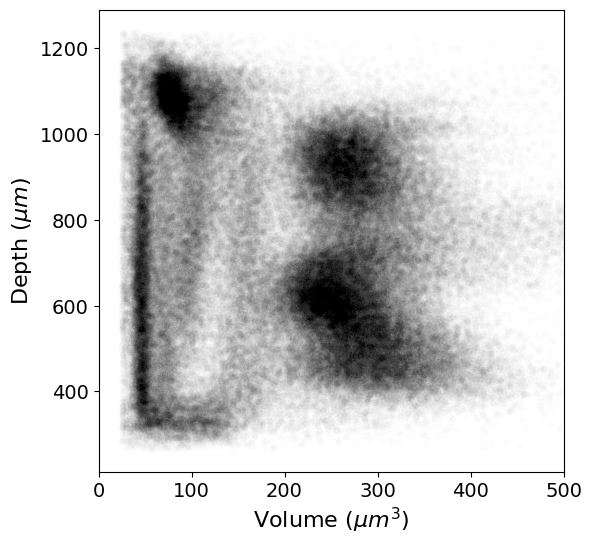

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=14)
sns.scatterplot(data=nucleus_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=False)
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

### Qerying cell type information 

There are two distinct ways cell types were classified in the MICrONS dataset: manual and automated. Manual annotations are available for ~1,000 neurons (`allen_v1_column_types_slanted_ref`), automated classifications are available for all cell bodies based on these manual annotations (`aibs_metamodel_celltypes_v661`). Because they are annotating an existing annotations, these annotations are introduced as a "reference" table:

In [17]:
cell_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True,
                                         merge_reference=False)
cell_df.head(5)

,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,36916,2023-12-19 22:47:18.659864+00:00,NaN,t,336365,excitatory_neuron,5P-IT
1,1070,2023-12-19 22:38:00.472115+00:00,NaN,t,110648,excitatory_neuron,23P
2,1099,2023-12-19 22:38:00.898837+00:00,NaN,t,112071,excitatory_neuron,23P
3,13259,2023-12-19 22:41:14.417986+00:00,NaN,t,197927,nonneuron,oligo
4,13271,2023-12-19 22:41:14.685474+00:00,NaN,t,198087,nonneuron,astrocyte


Reference annotations contain `target_id` to merge them onto the table they target (here: the nucleus table). But do not worry, CAVE automatically merges them onto their target table by default (`merge_reference=True`):

In [18]:
cell_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True)
cell_df.head(5)

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,...,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,...,723.328,1083.04,NaN,NaN,NaN,NaN,NaN,NaN,93606511657924288,864691136274724621
1,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,...,518.528,1016.40,NaN,NaN,NaN,NaN,NaN,NaN,79385153184885329,864691135489403194
2,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,...,597.888,623.32,NaN,NaN,NaN,NaN,NaN,NaN,79035988248401958,864691136147292311
3,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,...,744.768,1058.84,NaN,NaN,NaN,NaN,NaN,NaN,84529699506051734,864691136050858227
4,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,...,763.776,1094.44,NaN,NaN,NaN,NaN,NaN,NaN,83756261929388963,864691135809440972


The reference table added two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations.

In [19]:
cell_df["classification_system"].value_counts()

classification_system
excitatory_neuron    64195
nonneuron            21856
inhibitory_neuron     7963
Name: count, dtype: int64

In [20]:
cell_df["cell_type"].value_counts()

cell_type
23P          19735
4P           14777
6P-IT        11734
5P-IT         7949
astrocyte     7850
oligo         7020
6P-CT         6815
BC            3365
pericyte      2645
microglia     2638
MC            2466
5P-ET         2215
OPC           1703
BPC           1488
5P-NP          970
NGC            644
Name: count, dtype: int64

### EXERCISE 1: Location vs depth + cell types

Let's repeat our prior analysis but see if we can relate the patterns with cell type information. For this, we may first analyze the distributions of the difference types in the `classification_system`. Next, filter the table by `classification_system` to only `excitatory_neuron` and `inhibitory_neuron` using the `filter_in_dict` parameter and label the points by cell type.

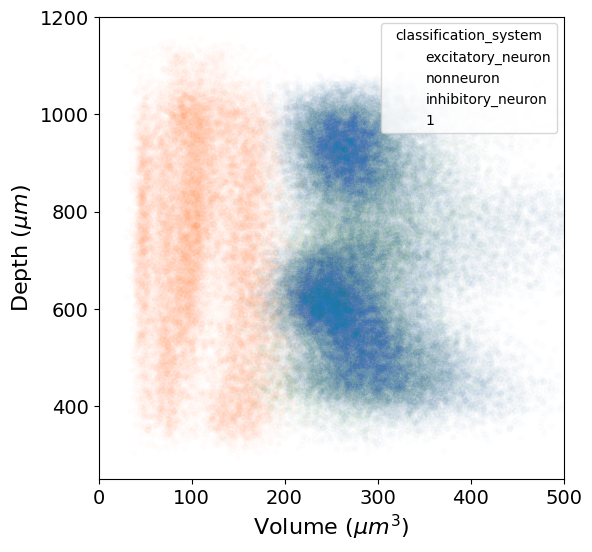

In [21]:
cell_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True)

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=14)
sns.scatterplot(data=cell_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=True, hue="classification_system")
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

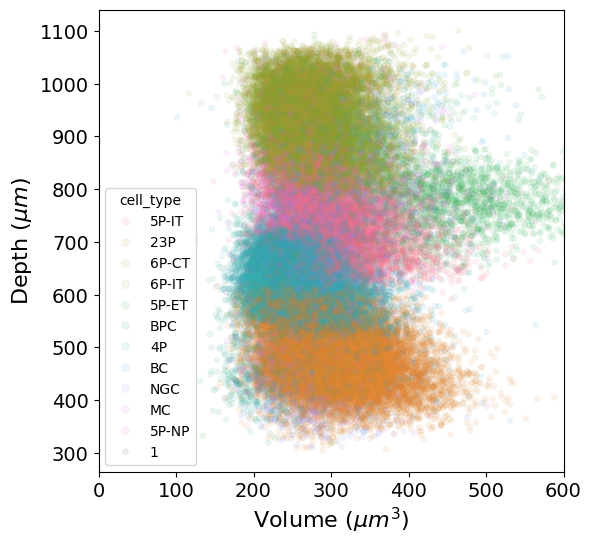

In [22]:
cell_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True,
                                        filter_in_dict={"classification_system": ["excitatory_neuron", "inhibitory_neuron"]})

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=14)
sns.scatterplot(data=cell_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.1, color="k", ax=ax, legend=True, hue="cell_type")
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 600)
plt.show()

## Query 3: Querying synapses and proofread neurons

### Proofread neurons

Proofreading is necessary to obtain accurate reconstructions of a cell. In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofread that only ~1,000 cells have proofread axons for which outputs can be used for analysis.

The table `proofreading_status_public_release` contains proofreading information about ~1,200 neurons. Axon annotations `extended` and `clean` can be used for analysis. We can obtain such cells by adding a filter to our query:

In [23]:
proof_df = client.materialize.query_table("proofreading_status_public_release", filter_in_dict={"status_axon": ["clean", "extended"]})

### Synapse query

The MICrONS dataset relies on automatically detected synapses for connectivity information. We automatically detected and associated a total of 337 million synaptic clefts. The detections were evaluated by manually identifying synapses in 70 small subvolumes (n=8,611 synapses) distributed across the dataset, giving the automated detection an estimated precision of 96% and recall of 89% with a partner assignment accuracy of 98%.

We can query the synapse table directly. However, it is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [24]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10)
syn_df

201 - "Limited query to 10 rows


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,4456,2020-11-04 13:02:08.388988+00:00,NaN,t,2956,72063160986635724,864691135533713769,72063160986635724,864691135533713769,"[52862, 102436, 20036]","[52862, 102436, 20036]","[52903, 102543, 20035]"
1,4503,2020-11-04 12:09:33.286834+00:00,NaN,t,344,72063092267156962,864691135087527094,72063092267156962,864691135087527094,"[53114, 102008, 20009]","[53114, 102008, 20009]","[53042, 102022, 20010]"
2,4508,2020-11-04 13:02:13.024144+00:00,NaN,t,344,72063229706111827,864691135533713769,72063229706111827,864691135533713769,"[53112, 102924, 20036]","[53112, 102924, 20036]","[53056, 102950, 20039]"
3,4568,2020-11-04 13:44:08.085705+00:00,NaN,t,13816,72133735889250131,864691134530418554,72133735889250131,864691134530418554,"[53348, 103862, 20073]","[53348, 103862, 20073]","[53274, 103794, 20072]"
4,4581,2020-11-04 07:29:12.917622+00:00,NaN,t,10436,72133804608718799,864691134745062676,72133804608718799,864691134745062676,"[53388, 104296, 20020]","[53388, 104296, 20020]","[53310, 104270, 20027]"
5,4582,2020-11-04 13:02:17.694701+00:00,NaN,t,1344,72063160986636743,864691135533713769,72063160986636743,864691135533713769,"[53220, 102280, 20036]","[53220, 102280, 20036]","[53254, 102208, 20038]"
6,4588,2020-11-04 12:20:12.290593+00:00,NaN,t,7128,72133942047682150,864691134609767690,72133942047682150,864691134609767690,"[53300, 105280, 20138]","[53300, 105280, 20138]","[53266, 105250, 20140]"
7,4590,2020-11-04 13:20:01.875310+00:00,NaN,t,6572,72133461011344162,864691135091400630,72133461011344162,864691135091400630,"[53376, 101610, 20129]","[53376, 101610, 20129]","[53334, 101649, 20130]"
8,4606,2020-11-04 07:24:39.038223+00:00,NaN,t,2100,72133667169766499,864691134609872906,72133667169766499,864691134609872906,"[53346, 103448, 20020]","[53346, 103448, 20020]","[53314, 103494, 20026]"
9,4611,2020-11-04 07:24:37.800341+00:00,NaN,t,492,72133735889243887,864691134609872906,72133735889243887,864691134609872906,"[53334, 103826, 20024]","[53334, 103826, 20024]","[53298, 103901, 20024]"


Instead we need to limit our query to a few neurons. We can query the graph spanned by the neurons with "clean" axons using the `filter_in_dict` parameter:

In [25]:
%%time 

synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": proof_df["pt_root_id"], 
                                                        "post_pt_root_id": proof_df["pt_root_id"]})

# remove autapses
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]
syn_df

CPU times: user 880 ms, sys: 373 ms, total: 1.25 s
Wall time: 2min 42s


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,107390513,2020-11-04 07:20:49.589809+00:00,NaN,t,8956,84746028015756884,864691134918370314,84746028015760442,864691135865167998,"[145276, 225228, 23059]","[145366, 225312, 23057]","[145304, 225286, 23058]"
1,144648847,2020-11-04 10:25:21.607615+00:00,NaN,t,5720,87827409285525264,864691135645645039,87827409285520659,864691136143786292,"[167926, 114800, 22586]","[167920, 114768, 22583]","[167926, 114776, 22585]"
2,137764071,2020-11-04 09:39:48.804128+00:00,NaN,t,21584,87478245288662989,864691135645645039,87548614032842358,864691135754259661,"[165404, 134804, 20002]","[165552, 134850, 20005]","[165480, 134802, 19999]"
3,158842100,2020-11-04 10:11:44.081977+00:00,NaN,t,4388,89443553671426299,864691135988854016,89443553671436885,864691135954940424,"[179326, 97414, 20932]","[179398, 97350, 20942]","[179384, 97362, 20935]"
4,169627147,2020-11-04 06:48:58.480065+00:00,NaN,t,1932,89951734335675875,864691135463863102,89951734335679095,864691137197468481,"[182892, 213374, 21604]","[182934, 213366, 21611]","[182868, 213324, 21608]"
...,...,...,...,...,...,...,...,...,...,...,...,...
125791,174663510,2020-11-04 12:25:38.564961+00:00,NaN,t,3412,90364875695847465,864691135842140387,90364875695834244,864691136388711031,"[186310, 145924, 20810]","[186396, 145854, 20802]","[186334, 145894, 20803]"
125792,366121350,2020-11-04 06:58:26.927935+00:00,NaN,t,2292,106193239601723104,864691136137140093,106193239601723256,864691136084747372,"[301400, 111546, 25703]","[301354, 111584, 25694]","[301432, 111560, 25697]"
125793,173155465,2020-11-04 12:09:23.605147+00:00,NaN,t,12116,90435107067937835,864691135586352764,90505475812124894,864691136388711031,"[186888, 144916, 21101]","[186990, 145024, 21091]","[186964, 144873, 21103]"
125794,172489911,2020-11-04 12:09:47.357445+00:00,NaN,t,4348,90434625964805473,864691135586352764,90434625964795853,864691136388711031,"[186540, 141422, 20851]","[186654, 141454, 20845]","[186584, 141386, 20850]"


Compared to the nucleus table, the synapse table has two points which were associated with segments (`pre_pt_position` and `post_pt_position`). The associated root ID columns are `pre_pt_root_id` and `post_pt_root_id`. 

Using pandas pivot function, we can transform this table into a matrix and plot it:

In [26]:
syn_mat = syn_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", values="size", aggfunc="sum")

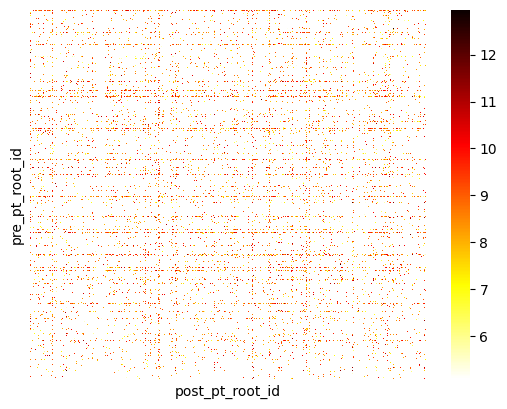

In [27]:
sns.heatmap(np.log(syn_mat), cmap="hot_r", xticklabels=[], yticklabels=[])
plt.show()

## EXERCISE 2:

Combine the synapse table with the cell type table and sort the connectivity matrix accordingly.

## Query 3 - Functional properties

Before acquiring the EM dataset, the activity of the cells in the same region was recorded using calcium imaging (excitatory neurons only). Joint analysis of the connectivity and functional data is possible for neurons that have been coregistered between the two datasets. Currently there are 10,630 such neurons, some of them were imaged in multiple sessions. 

Here, we provide a table with functional properties of these neurons. Obtaining their raw calcium traces along with the associated stimulus video is possible but beyond the scope of this tutorial. The table `functional_properties_v3_bcm` contains functional properties as outlined in the description:

In [28]:
print(client.materialize.get_table_metadata("functional_properties_v3_bcm")["description"])


Functional properties for pyramidal cells 

session: session index for the mouse
scan_idx: scan ID
unit_id: id for functional unit, unique per scan
pref_ori: preferred orientation in radians (0 - pi), horizontal bar moving upward is 0 and orientation increases clockwise, extracted from model responses to oriented noise stimuli
pref_dir: preferred direction in radians (0 - 2pi), horizontal bar moving upward is 0 and orientation increases clockwise, extracted from model responses to oriented noise stimuli
gOSI: global orientation selectivity index
gDSI: global direction selectivity index
readout_weight: readout weight vector
readout_location_x: x coordinate of the readout location per unit, in a 128 * 72 downsampled stimulus space, this is an approximation of a neuron's receptive field center
readout_location_y: y coordinate of the readout location per unit, in a 128 * 72 downsampled stimulus space, this is an approximation of a neuron's receptive field center
cc_abs: prediction perform

In [29]:
func_df = client.materialize.query_table("functional_properties_v3_bcm")
func_df

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,...,scan_idx,unit_id,pref_ori,pref_dir,gOSI,gDSI,cc_abs,pt_position,bb_start_position,bb_end_position
0,582276,2020-09-28 22:41:42.536121+00:00,t,274.291589,111332012547320963,864691135738685297,11668,2024-01-22 08:09:51.497934+00:00,t,582276,...,5,4909,1.512059,4.653652,0.166767,0.015285,0.571207,"[338720, 125232, 19589]","[nan, nan, nan]","[nan, nan, nan]"
1,293318,2020-09-28 22:45:23.572432+00:00,t,430.108180,90783515419343652,864691135502985397,414,2024-01-22 08:09:51.497934+00:00,t,293318,...,4,8066,1.407509,4.549102,0.090610,0.101717,0.296396,"[189472, 119296, 26037]","[nan, nan, nan]","[nan, nan, nan]"
2,332833,2020-09-28 22:44:41.864456+00:00,t,274.418729,93535317407139914,864691135387371905,6950,2024-01-22 08:09:51.497934+00:00,t,332833,...,7,6413,0.034229,3.175822,0.345478,0.225768,0.372098,"[209328, 174304, 20004]","[nan, nan, nan]","[nan, nan, nan]"
3,295460,2020-09-28 22:41:24.368712+00:00,t,208.616653,90225718084406516,864691135661410544,10081,2024-01-22 08:09:51.497934+00:00,t,295460,...,3,7748,1.586712,1.586712,0.208914,0.035112,0.446928,"[185088, 157776, 15691]","[nan, nan, nan]","[nan, nan, nan]"
4,585835,2020-09-28 22:41:12.649674+00:00,t,325.562860,111336342008911475,864691135349275351,11085,2024-01-22 08:09:51.497934+00:00,t,585835,...,5,7441,1.598579,4.740172,0.146034,0.071207,-0.011697,"[338864, 157856, 20916]","[nan, nan, nan]","[nan, nan, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12089,395416,2020-09-28 22:44:46.280352+00:00,t,282.205061,97825062761246370,864691135394864117,2501,2024-01-22 08:09:51.497934+00:00,t,395416,...,3,2456,2.523049,5.664642,0.055368,0.039385,0.081808,"[240528, 154032, 25770]","[nan, nan, nan]","[nan, nan, nan]"
12090,395416,2020-09-28 22:44:46.280352+00:00,t,282.205061,97825062761246370,864691135394864117,4031,2024-01-22 08:09:51.497934+00:00,t,395416,...,3,4759,2.831182,2.831182,0.097636,0.065452,0.178006,"[240528, 154032, 25770]","[nan, nan, nan]","[nan, nan, nan]"
12091,485825,2020-09-28 22:41:48.027148+00:00,t,371.868795,105277895836000216,864691136966674894,9984,2024-01-22 08:09:51.497934+00:00,t,485825,...,6,1538,3.019752,3.019752,0.243581,0.136095,0.057006,"[294512, 107648, 23083]","[nan, nan, nan]","[nan, nan, nan]"
12092,298963,2020-09-28 22:41:58.201776+00:00,t,280.505385,91354023978086624,864691135783565875,7972,2024-01-22 08:09:51.497934+00:00,t,298963,...,7,6479,3.119192,3.119192,0.671636,0.078108,0.871441,"[193408, 175408, 21696]","[nan, nan, nan]","[nan, nan, nan]"


<Axes: xlabel='gOSI', ylabel='Count'>

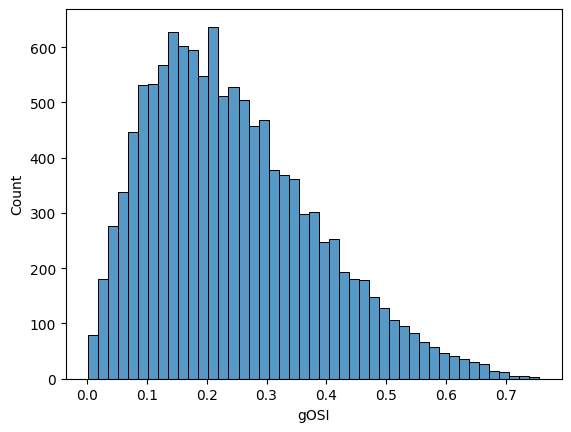

In [30]:
sns.histplot(data=func_df, x="gOSI")

In [31]:
len(func_df["pt_root_id"].unique())

10630

<Axes: xlabel='pref_ori', ylabel='Count'>

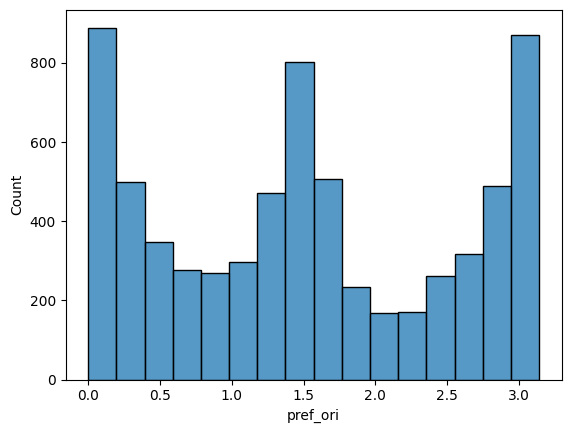

In [32]:
sns.histplot(data=func_df[func_df["gOSI"] > .2], x="pref_ori")

<Axes: xlabel='pref_dir', ylabel='Count'>

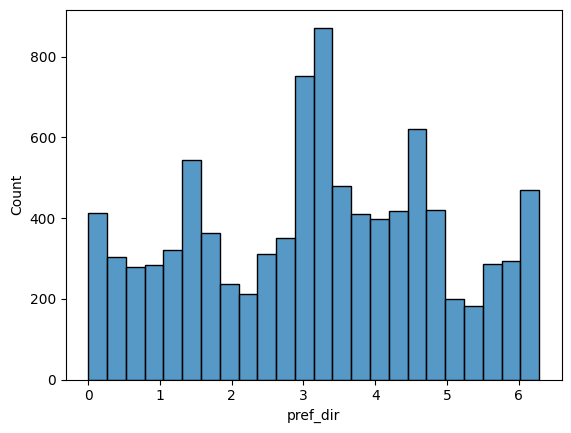

In [33]:
sns.histplot(data=func_df[func_df["gDSI"] > .05], x="pref_dir")

## EXERCISE 3: Relate structure and function

This is an open-ended analysis question. 

In [34]:
func_ded_df = func_df.drop_duplicates("pt_root_id", keep="first")
syn_df

syn_func_df = syn_df.drop_duplicates(["pre_pt_root_id", "post_pt_root_id"], keep="first")

syn_func_df = pd.merge(syn_func_df, func_ded_df[["pt_root_id", "pref_ori"]].rename(columns={"pt_root_id": "pre_pt_root_id", "pref_ori": "pre_pref_ori"}), on="pre_pt_root_id")
syn_func_df = pd.merge(syn_func_df, func_ded_df[["pt_root_id", "pref_ori"]].rename(columns={"pt_root_id": "post_pt_root_id", "pref_ori": "post_pref_ori"}), on="post_pt_root_id")
syn_func_df["pref_ori_d"] = (syn_func_df["pre_pref_ori"] - syn_func_df["post_pref_ori"]) % np.pi / 2

In [35]:
syn_rand_df = syn_df.copy()
syn_rand_df = syn_rand_df.drop_duplicates(["pre_pt_root_id", "post_pt_root_id"], keep="first")

rand_idx = np.arange(len(syn_rand_df))
np.random.shuffle(rand_idx)

syn_rand_df["post_pt_root_id"] = np.array(syn_rand_df["post_pt_root_id"].iloc[rand_idx], dtype=int)
syn_rand_df = syn_rand_df.drop_duplicates(["pre_pt_root_id", "post_pt_root_id"], keep="first")
syn_rand_df = syn_rand_df[syn_rand_df["pre_pt_root_id"] != syn_rand_df["post_pt_root_id"]]
syn_rand_func_df = pd.merge(syn_rand_df, func_ded_df[["pt_root_id", "pref_ori"]].rename(columns={"pt_root_id": "pre_pt_root_id", "pref_ori": "pre_pref_ori"}), on="pre_pt_root_id")
syn_rand_func_df = pd.merge(syn_rand_func_df, func_ded_df[["pt_root_id", "pref_ori"]].rename(columns={"pt_root_id": "post_pt_root_id", "pref_ori": "post_pref_ori"}), on="post_pt_root_id")
syn_rand_func_df["pref_ori_d"] = (syn_rand_func_df["pre_pref_ori"] - syn_rand_func_df["post_pref_ori"]) % np.pi / 2

In [36]:
syn_func_df.shape, syn_rand_func_df.shape

((4187, 15), (4649, 15))

<Axes: xlabel='pref_ori_d', ylabel='Count'>

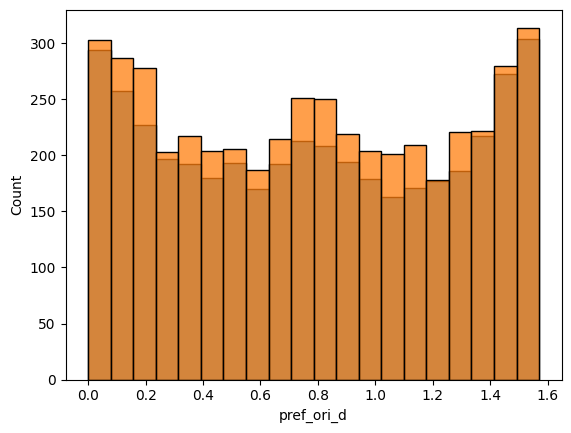

In [37]:
sns.histplot(data=syn_func_df, x="pref_ori_d", bins=20)
sns.histplot(data=syn_rand_func_df, x="pref_ori_d", bins=20)

<Axes: xlabel='pref_ori_d', ylabel='Count'>

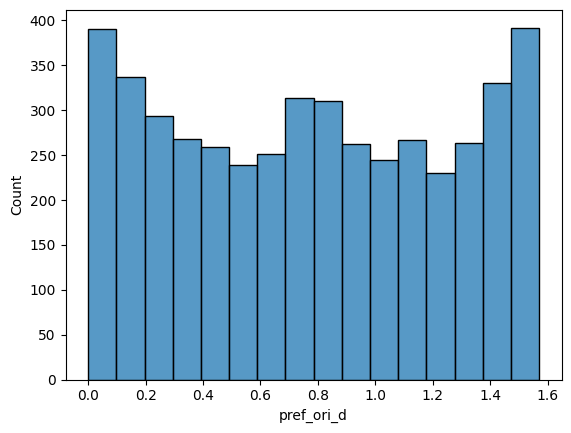

In [38]:
sns.histplot(data=syn_rand_func_df, x="pref_ori_d")